# Patient-Wise Data Splitting
**Critical:** Split by patient_id to prevent data leakage

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load Filtered Dataset

In [2]:
# Load the CSV
csv_path = '/scratch1/e20-fyp-ecg-ihd-detection/data/raw/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_ecg_labels_mi_vs_normal_scp100_human.csv'
df = pd.read_csv(csv_path)

print("Dataset loaded successfully!")
print(f"Total ECG records: {len(df)}")
print(f"Unique patients: {df['patient_id'].nunique()}")
print(f"\nClass distribution:")
print(df['label_ecg_binary'].value_counts())
print(f"\nClass percentages:")
print(df['label_ecg_binary'].value_counts(normalize=True) * 100)

df.head()

Dataset loaded successfully!
Total ECG records: 7593
Unique patients: 7141

Class distribution:
label_ecg_binary
0    5848
1    1745
Name: count, dtype: int64

Class percentages:
label_ecg_binary
0    77.018306
1    22.981694
Name: proportion, dtype: float64


,ecg_id,patient_id,label_ecg_binary,normal_group,mi_group,diag_classes_any_str,diag_subclasses_100_str,age,sex,pacemaker,validated_by_human,strat_fold,filename_lr,filename_hr,recording_date
0,1,15709,0,pure_normal,no_mi,NORM,NORM,56,1,NaN,True,3,records100/00000/00001_lr,records500/00000/00001_hr,09/11/1984 09:17
1,3,20372,0,pure_normal,no_mi,NORM,NORM,37,1,NaN,True,5,records100/00000/00003_lr,records500/00000/00003_hr,15/11/1984 12:49
2,4,17014,0,pure_normal,no_mi,NORM,NORM,24,0,NaN,True,3,records100/00000/00004_lr,records500/00000/00004_hr,15/11/1984 13:44
3,5,17448,0,pure_normal,no_mi,NORM,NORM,19,1,NaN,True,4,records100/00000/00005_lr,records500/00000/00005_hr,17/11/1984 10:43
4,6,19005,0,pure_normal,no_mi,NORM,NORM,18,1,NaN,True,4,records100/00000/00006_lr,records500/00000/00006_hr,28/11/1984 13:32


In [3]:
# Check for patients with multiple ECGs
ecgs_per_patient = df.groupby('patient_id').size()
print(f"\nPatients with multiple ECGs: {(ecgs_per_patient > 1).sum()}")
print(f"Max ECGs per patient: {ecgs_per_patient.max()}")
print(f"Average ECGs per patient: {ecgs_per_patient.mean():.2f}")

# Show examples of patients with multiple ECGs
multi_ecg_patients = ecgs_per_patient[ecgs_per_patient > 1].head(5)
print(f"\nExample patients with multiple ECGs:")
for patient_id, count in multi_ecg_patients.items():
    print(f"  Patient {patient_id}: {count} ECGs")


Patients with multiple ECGs: 372
Max ECGs per patient: 7
Average ECGs per patient: 1.06

Example patients with multiple ECGs:
  Patient 310: 2 ECGs
  Patient 317: 2 ECGs
  Patient 332: 2 ECGs
  Patient 337: 2 ECGs
  Patient 339: 2 ECGs


## 2. Patient-Wise Splitting (CRITICAL STEP)

In [4]:
# Step 1: Get unique patients with their majority label
# (In case a patient has both normal and MI ECGs, use majority)
patient_labels = df.groupby('patient_id')['label_ecg_binary'].agg(lambda x: x.mode()[0]).reset_index()
patient_labels.columns = ['patient_id', 'patient_label']

print(f"Total unique patients: {len(patient_labels)}")
print(f"\nPatient-level class distribution:")
print(patient_labels['patient_label'].value_counts())

# Step 2: Split patients (70% train, 15% val, 15% test)
# First split: 70% train, 30% temp
train_patients, temp_patients = train_test_split(
    patient_labels['patient_id'].values,
    test_size=0.30,
    stratify=patient_labels['patient_label'].values,
    random_state=42
)

# Second split: 50% val, 50% test (from the 30% temp)
temp_labels = patient_labels[patient_labels['patient_id'].isin(temp_patients)]
val_patients, test_patients = train_test_split(
    temp_patients,
    test_size=0.50,
    stratify=temp_labels['patient_label'].values,
    random_state=42
)

print(f"\nPatient split:")
print(f"  Train patients: {len(train_patients)} ({len(train_patients)/len(patient_labels)*100:.1f}%)")
print(f"  Val patients: {len(val_patients)} ({len(val_patients)/len(patient_labels)*100:.1f}%)")
print(f"  Test patients: {len(test_patients)} ({len(test_patients)/len(patient_labels)*100:.1f}%)")

Total unique patients: 7141

Patient-level class distribution:
patient_label
0    5597
1    1544
Name: count, dtype: int64

Patient split:
  Train patients: 4998 (70.0%)
  Val patients: 1071 (15.0%)
  Test patients: 1072 (15.0%)


## 3. Verify No Patient Leakage

In [5]:
# CRITICAL CHECK: Verify no overlap
train_set = set(train_patients)
val_set = set(val_patients)
test_set = set(test_patients)

train_val_overlap = train_set & val_set
train_test_overlap = train_set & test_set
val_test_overlap = val_set & test_set

print("\n" + "="*50)
print("DATA LEAKAGE CHECK (MUST BE ZERO)")
print("="*50)
print(f"Train-Val overlap: {len(train_val_overlap)} patients")
print(f"Train-Test overlap: {len(train_test_overlap)} patients")
print(f"Val-Test overlap: {len(val_test_overlap)} patients")

if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
    print("\n✅ SUCCESS: No patient leakage detected!")
else:
    print("\n❌ ERROR: Patient leakage detected! Check splitting logic.")
print("="*50)


DATA LEAKAGE CHECK (MUST BE ZERO)
Train-Val overlap: 0 patients
Train-Test overlap: 0 patients
Val-Test overlap: 0 patients

✅ SUCCESS: No patient leakage detected!


## 4. Map Patients Back to ECG Records

In [6]:
# Create masks for ECG records based on patient assignment
train_mask = df['patient_id'].isin(train_patients)
val_mask = df['patient_id'].isin(val_patients)
test_mask = df['patient_id'].isin(test_patients)

# Split dataframes
df_train = df[train_mask].copy()
df_val = df[val_mask].copy()
df_test = df[test_mask].copy()

print(f"\nECG record split:")
print(f"  Train: {len(df_train)} ECGs from {df_train['patient_id'].nunique()} patients")
print(f"  Val: {len(df_val)} ECGs from {df_val['patient_id'].nunique()} patients")
print(f"  Test: {len(df_test)} ECGs from {df_test['patient_id'].nunique()} patients")
print(f"  Total: {len(df_train) + len(df_val) + len(df_test)} ECGs")

# Verify class distribution in each split
print(f"\nClass distribution in splits:")
print(f"\nTrain:")
print(df_train['label_ecg_binary'].value_counts())
print(f"Ratio: {df_train['label_ecg_binary'].value_counts(normalize=True).values}")

print(f"\nValidation:")
print(df_val['label_ecg_binary'].value_counts())
print(f"Ratio: {df_val['label_ecg_binary'].value_counts(normalize=True).values}")

print(f"\nTest:")
print(df_test['label_ecg_binary'].value_counts())
print(f"Ratio: {df_test['label_ecg_binary'].value_counts(normalize=True).values}")


ECG record split:
  Train: 5320 ECGs from 4998 patients
  Val: 1136 ECGs from 1071 patients
  Test: 1137 ECGs from 1072 patients
  Total: 7593 ECGs

Class distribution in splits:

Train:
label_ecg_binary
0    4095
1    1225
Name: count, dtype: int64
Ratio: [0.76973684 0.23026316]

Validation:
label_ecg_binary
0    870
1    266
Name: count, dtype: int64
Ratio: [0.76584507 0.23415493]

Test:
label_ecg_binary
0    883
1    254
Name: count, dtype: int64
Ratio: [0.7766051 0.2233949]


## 5. Visualize Splits

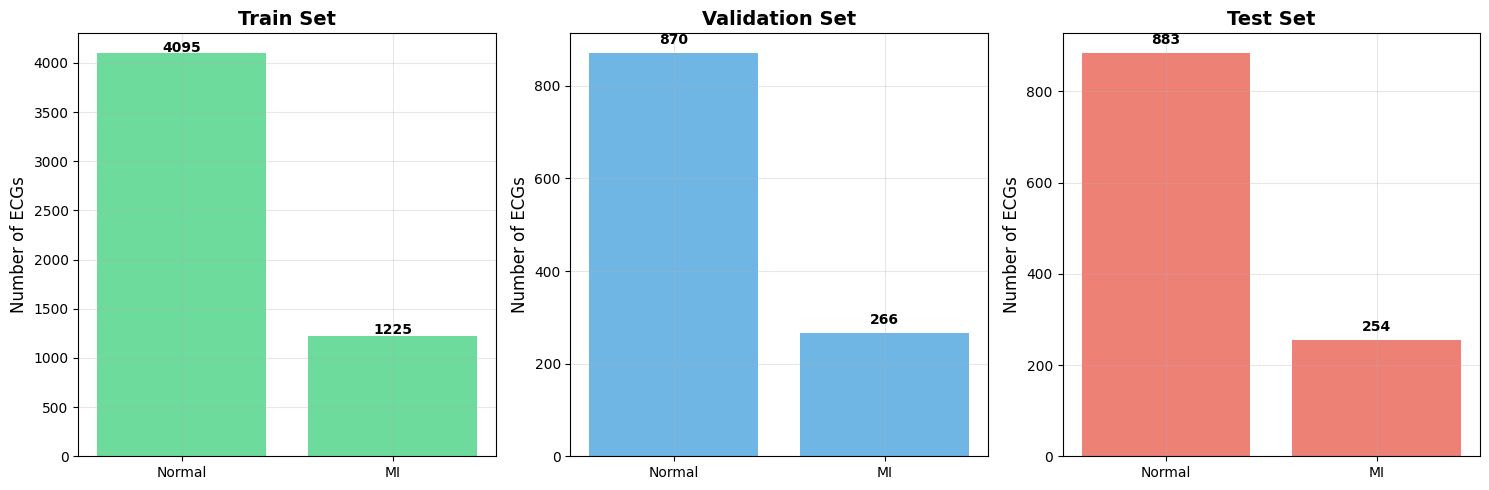

✅ Saved: data_split_distribution.png


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

splits = [df_train, df_val, df_test]
split_names = ['Train', 'Validation', 'Test']
colors = ['#2ecc71', '#3498db', '#e74c3c']

for ax, split_df, name, color in zip(axes, splits, split_names, colors):
    counts = split_df['label_ecg_binary'].value_counts()
    ax.bar(['Normal', 'MI'], [counts[0], counts[1]], color=color, alpha=0.7)
    ax.set_title(f'{name} Set', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of ECGs', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add counts on bars
    for i, v in enumerate([counts[0], counts[1]]):
        ax.text(i, v + 20, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/data_split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: data_split_distribution.png")

## 6. Save Split Indices

In [8]:
# Save patient IDs for each split
np.save('../data/train_patient_ids.npy', train_patients)
np.save('../data/val_patient_ids.npy', val_patients)
np.save('../data/test_patient_ids.npy', test_patients)

# Save ECG indices
np.save('../data/train_indices.npy', df_train.index.values)
np.save('../data/val_indices.npy', df_val.index.values)
np.save('../data/test_indices.npy', df_test.index.values)

# Save full dataframes for easy loading
df_train.to_csv('../data/train_metadata.csv', index=False)
df_val.to_csv('../data/val_metadata.csv', index=False)
df_test.to_csv('../data/test_metadata.csv', index=False)

print("✅ Saved all split files to ../data/")
print("\nFiles created:")
print("  • train/val/test_patient_ids.npy")
print("  • train/val/test_indices.npy")
print("  • train/val/test_metadata.csv")

✅ Saved all split files to ../data/

Files created:
  • train/val/test_patient_ids.npy
  • train/val/test_indices.npy
  • train/val/test_metadata.csv


## 7. Summary Statistics

In [9]:
summary = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'ECGs': [len(df_train), len(df_val), len(df_test), len(df)],
    'Patients': [df_train['patient_id'].nunique(), 
                 df_val['patient_id'].nunique(), 
                 df_test['patient_id'].nunique(),
                 df['patient_id'].nunique()],
    'Normal': [len(df_train[df_train['label_ecg_binary']==0]),
               len(df_val[df_val['label_ecg_binary']==0]),
               len(df_test[df_test['label_ecg_binary']==0]),
               len(df[df['label_ecg_binary']==0])],
    'MI': [len(df_train[df_train['label_ecg_binary']==1]),
           len(df_val[df_val['label_ecg_binary']==1]),
           len(df_test[df_test['label_ecg_binary']==1]),
           len(df[df['label_ecg_binary']==1])]
})

summary['Normal %'] = (summary['Normal'] / summary['ECGs'] * 100).round(1)
summary['MI %'] = (summary['MI'] / summary['ECGs'] * 100).round(1)

print("\n" + "="*70)
print("FINAL SUMMARY - PATIENT-WISE SPLIT")
print("="*70)
print(summary.to_string(index=False))
print("="*70)

# Save summary
summary.to_csv('../results/metrics/data_split_summary.csv', index=False)
print("\n✅ Saved summary to: results/metrics/data_split_summary.csv")


FINAL SUMMARY - PATIENT-WISE SPLIT
     Split  ECGs  Patients  Normal   MI  Normal %  MI %
     Train  5320      4998    4095 1225      77.0  23.0
Validation  1136      1071     870  266      76.6  23.4
      Test  1137      1072     883  254      77.7  22.3
     Total  7593      7141    5848 1745      77.0  23.0

✅ Saved summary to: results/metrics/data_split_summary.csv
